In [1]:
import os
from glob import glob

import tensorflow as tf
import numpy as np
import pandas as pd

from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

seed = 13
tf.random.set_seed(seed)
np.random.seed(seed)

data_root = os.path.join("..", "data", "dogs-vs-cats")
train_dir = os.path.join(data_root, "train")
test_dir = os.path.join(data_root, "test1")

# Helper to flatten cat/dog folders into a labeled dataframe
def build_labeled_df(directory):
    filepaths = sorted(glob(os.path.join(directory, "*", "*.jpg")))
    labels = [os.path.basename(os.path.dirname(fp)) for fp in filepaths]
    return pd.DataFrame({"file": filepaths, "label": labels})

train_df = build_labeled_df(train_dir)
train_df.head()

2025-12-08 17:48:29.538652: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


,file,label
0,../data/dogs-vs-cats/train/cat/cat.0.jpg,cat
1,../data/dogs-vs-cats/train/cat/cat.1.jpg,cat
2,../data/dogs-vs-cats/train/cat/cat.10.jpg,cat
3,../data/dogs-vs-cats/train/cat/cat.100.jpg,cat
4,../data/dogs-vs-cats/train/cat/cat.1000.jpg,cat


In [2]:
train_df["label"].value_counts()

label
cat    12500
dog    12500
Name: count, dtype: int64

In [3]:
test_files = sorted(glob(os.path.join(test_dir, "*.jpg")))
test_df = pd.DataFrame({"file": test_files})
test_df.head()

,file
0,../data/dogs-vs-cats/test1/1.jpg
1,../data/dogs-vs-cats/test1/10.jpg
2,../data/dogs-vs-cats/test1/100.jpg
3,../data/dogs-vs-cats/test1/1000.jpg
4,../data/dogs-vs-cats/test1/10000.jpg


In [4]:
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(
    train_df, test_size = 0.2, stratify = train_df["label"], random_state=13
)

In [5]:
train_datagen = ImageDataGenerator(
    rotation_range=15, horizontal_flip=True, preprocessing_function=preprocess_input
)

val_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input
)

In [6]:
batch_size = 16

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col="file",
    y_col="label",
    class_mode="categorical",
    target_size=(224, 224),
    batch_size=batch_size,
    shuffle=True,
    seed=13
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    x_col="file",
    y_col="label",
    class_mode="categorical",
    target_size=(224, 224),
    batch_size=batch_size,
    seed=13,
)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


In [7]:
base_model = VGG16(weights="imagenet", input_shape=(224, 224, 3), include_top=False)

I0000 00:00:1765183723.527635   44457 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4539 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5


In [8]:
base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### 가중치가 학습되지 않도록 잠궈버리자

In [9]:
for layers in base_model.layers:
    layers.trainable = False

base_model.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [10]:
def vgg16_pretrained():
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(100, activation="relu"),
        Dropout(0.4),
        Dense(64, activation="relu"),
        Dense(64, activation="relu"),
        Dense(2, activation="softmax"),
    ])
    return model

In [11]:
tf.keras.backend.clear_session()

In [12]:
model = vgg16_pretrained()
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"] )
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        51,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         6,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,776,742 (56.37 MB)

 Trainable params: 62,054 (242.40 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [13]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_accuracy", patience=2, verbose=1, factor=0.5, min_lr=1e-9
)

In [14]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy", patience=5, verbose=1, mode="max"
)

In [15]:
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    monitor="val_accuracy",
    filepath="catdog_vgg16_.{epoch:02d}-{val_accuracy:.6f}.weights.h5",
    verbose=1,
    save_best_only=True,
    save_weights_only=True,
)

In [16]:
history = model.fit(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    validation_steps=val_data.shape[0] // batch_size,
    steps_per_epoch=train_data.shape[0] // batch_size,
    callbacks=[reduce_lr, early_stopping, checkpoint],
)

Epoch 1/5


2025-12-08 17:48:51.428742: I external/local_xla/xla/service/service.cc:163] XLA service 0x7c5a4000f3e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-08 17:48:51.428775: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 2060, Compute Capability 7.5
2025-12-08 17:48:51.474828: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-08 17:48:52.007330: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700
2025-12-08 17:48:52.007330: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91700
2025-12-08 17:48:52.477355: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[16,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[16,3,224,224]

   2/1250 ━━━━━━━━━━━━━━━━━━━━ 1:34 76ms/step - accuracy: 0.4531 - loss: 3.0281 

I0000 00:00:1765183738.616849   44558 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9318 - loss: 0.1971
Epoch 1: val_accuracy improved from None to 0.98377, saving model to catdog_vgg16_.01-0.983774.weights.h5

Epoch 1: val_accuracy improved from None to 0.98377, saving model to catdog_vgg16_.01-0.983774.weights.h5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 223s 171ms/step - accuracy: 0.9590 - loss: 0.1112 - val_accuracy: 0.9838 - val_loss: 0.0430 - learning_rate: 0.0010
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 223s 171ms/step - accuracy: 0.9590 - loss: 0.1112 - val_accuracy: 0.9838 - val_loss: 0.0430 - learning_rate: 0.0010
Epoch 2/5
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9742 - loss: 0.0692
Epoch 2: val_accuracy did not improve from 0.98377
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 187s 150ms/step - accuracy: 0.9753 - loss: 0.0662 - val_accuracy: 0.9822 - val_loss: 0.0425 - learning_rate: 0.0010
Epoch 3/5

Epoch 2: val_accuracy did not improve from 0.98377
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 187s 150ms/step - accura

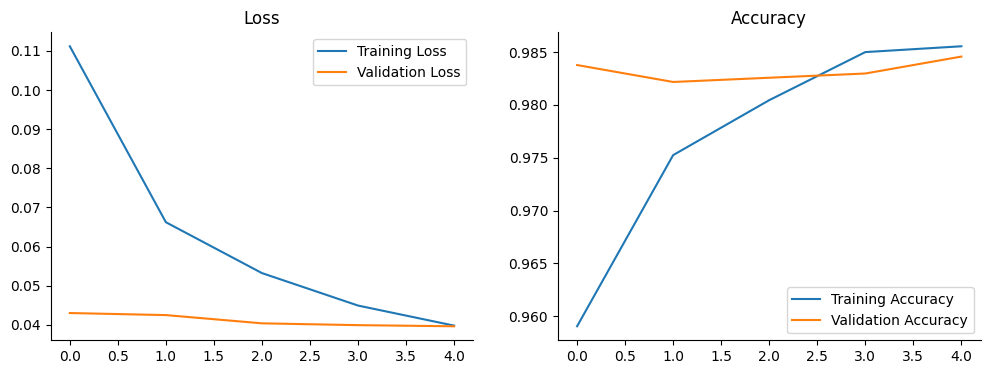

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

sns.lineplot(
    x=range(len(history.history["loss"])),
    y=history.history["loss"],
    ax=axes[0],
    label="Training Loss",
)
sns.lineplot(
    x=range(len(history.history["loss"])),
    y=history.history["val_loss"],
    ax=axes[0],
    label="Validation Loss",
)

sns.lineplot(
    x=range(len(history.history["accuracy"])),
    y=history.history["accuracy"],
    ax=axes[1],
    label="Training Accuracy",
)
sns.lineplot(
    x=range(len(history.history["accuracy"])),
    y=history.history["val_accuracy"],
    ax=axes[1],
    label="Validation Accuracy",
)

axes[0].set_title("Loss")
axes[1].set_title("Accuracy")

sns.despine()
plt.show()

In [18]:
val_loss, val_accuracy = model.evaluate(val_generator)

print(f"Validation Accuracy : {val_accuracy: .4f}")
print(f"Validation Loss : {val_loss: .4f}")

312/313 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.9842 - loss: 0.0365

2025-12-08 18:05:12.988269: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[8,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,3,224,224]{3,2,1,0}, f32[64,3,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="__cudnn$convBiasActivationForward", backend_config={"operation_queue_id":"0","wait_on_operation_queues":[],"cudnn_conv_backend_config":{"activation_mode":"kRelu","conv_result_scale":1,"side_input_scale":0,"leakyrelu_alpha":0},"force_earliest_schedule":false,"reification_cost":[]}
2025-12-08 18:05:13.046196: I external/local_xla/xla/service/gpu/autotuning/conv_algorithm_picker.cc:546] Omitted potentially buggy algorithm eng14{k25=2} for conv (f32[8,64,224,224]{3,2,1,0}, u8[0]{0}) custom-call(f32[8,64,224,224]{3,2,1,0}, f32[64,64,3,3]{3,2,1,0}, f32[64]{0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, custom_call_target="_

313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.9846 - loss: 0.0396
313/313 ━━━━━━━━━━━━━━━━━━━━ 28s 89ms/step - accuracy: 0.9846 - loss: 0.0396
Validation Accuracy :  0.9846
Validation Loss :  0.0396
Validation Accuracy :  0.9846
Validation Loss :  0.0396


In [19]:
val_pred = model.predict(val_generator)

313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 25s 79ms/step


In [20]:
val_data.loc[:, "val_pred"] = np.argmax(val_pred, axis=1)
labels = dict((v, k) for k, v in val_generator.class_indices.items())
val_data.loc[:, "val_pred"] = val_data.loc[:, "val_pred"].map(labels)

val_data.head(10)

/tmp/ipykernel_44457/349242900.py:3: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '['dog' 'dog' 'cat' ... 'dog' 'dog' 'dog']' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  val_data.loc[:, "val_pred"] = val_data.loc[:, "val_pred"].map(labels)


,file,label,val_pred
3826,../data/dogs-vs-cats/train/cat/cat.2191.jpg,cat,dog
21997,../data/dogs-vs-cats/train/dog/dog.7296.jpg,dog,dog
7776,../data/dogs-vs-cats/train/cat/cat.5747.jpg,cat,cat
18531,../data/dogs-vs-cats/train/dog/dog.4176.jpg,dog,dog
20437,../data/dogs-vs-cats/train/dog/dog.5892.jpg,dog,cat
3369,../data/dogs-vs-cats/train/cat/cat.1780.jpg,cat,cat
21165,../data/dogs-vs-cats/train/dog/dog.6547.jpg,dog,cat
12973,../data/dogs-vs-cats/train/dog/dog.10422.jpg,dog,dog
8944,../data/dogs-vs-cats/train/cat/cat.6799.jpg,cat,cat
1811,../data/dogs-vs-cats/train/cat/cat.11627.jpg,cat,cat


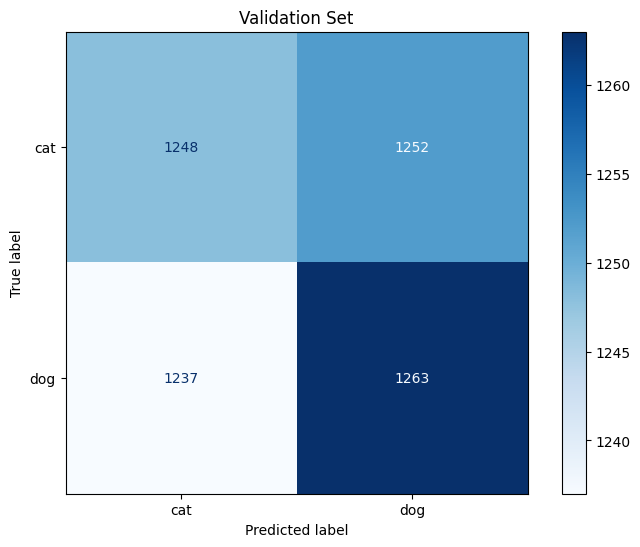

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(9, 6))

cm = confusion_matrix(val_data["label"], val_data["val_pred"])

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["cat", "dog"])
disp.plot(cmap=plt.cm.Blues, ax=ax)

ax.set_title("Validation Set")
plt.show()